### 1. Linear Regression

In [2]:
import numpy as np
from numpy import ndarray
from typing import Dict, Tuple

##### 1.1. Defining The Model

In [3]:
def forward_linear_regression(X_batch: ndarray,
                              y_batch: ndarray,
                              weights: Dict[str, ndarray]) -> Tuple[float, Dict[str, ndarray]]:
    
    assert X_batch.shape[0] == y_batch.shape[0]
    assert X_batch.shape[1] == weights['W'].shape[0]
    assert weights['B'].shape[0] == weights['B'].shape[1] == 1

    N = np.dot(X_batch, weights['W'])

    P = N + weights['B']

    D = y_batch - P

    D2 = np.power(D, 2)

    # mean squared error (the aggregator)
    loss = np.mean(D2)

    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X_batch
    forward_info['N'] = N
    forward_info['P'] = P
    forward_info['D'] = D
    forward_info['D2'] = D2
    forward_info['y'] = y_batch

    return loss, forward_info

##### 1.2. Training The Model

calculating the gradients

In [4]:
def loss_gradients(forward_info: Dict[str, ndarray],
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    
    batch_size = forward_info['X'].shape[0]

    # dLdD
    dLdD = 2 * forward_info['D']

    dDdP = -1 * np.ones_like(forward_info['P'])

    dPdN = np.ones_like(weights['B'])

    dPdB = np.ones_like(forward_info['N'])

    # dLdN and dLdB
    dLdN = dLdD * dDdP * dPdN
    dLdB = (dLdD * dDdP * dPdB).sum(axis=0)

    dNdX = np.transpose(weights['W'], (1, 0))
    dNdW = np.transpose(forward_info['X'], (1, 0))

    # dLdX and dLdW, we need to dot product here
    # because it was using dot product to calculate N, with dNdW on the left for dLdW
    dLdX = np.dot(dLdN, dNdX)
    dLdW = np.dot(dNdW, dLdN)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W'] = dLdW
    loss_gradients['B'] = dLdB

    return loss_gradients

Use the gradients to train the model.

Now we’ll simply run the following procedure over and over again:
1. Select a batch of data
2. Run the forward pass of the model
3. Run the backward pass of the model using the info computed on the forward pass
4. Use the gradients computed on the backward pass to update the weights
5. Go to the next epoch

In [5]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

Creating the dataset

In [26]:
X, y = make_regression(n_samples=100, n_features=3, noise=1, random_state=42)
y = y.reshape(-1, 1)

Function to generate a batch of data

In [17]:
Batch = Tuple[ndarray, ndarray]
def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

Function to permute/shuffle the dataset

In [18]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

Function to Initialize weights random gaussian

In [19]:
def init_weights(n_in: int) -> Dict[str, ndarray]:
    '''
    Initialize weights on first forward pass of model.
    '''
    
    weights: Dict[str, ndarray] = {}
    W = np.random.randn(n_in, 1)
    B = np.random.randn(1, 1)
    
    weights['W'] = W
    weights['B'] = B

    return weights

Function for training the Regressor

In [42]:
def train(X: ndarray,
          y: ndarray,
          epochs: int = 100,
          learning_rate: float = 0.001,
          batch_size: int = 8,
          return_losses: bool = False,
          return_weights: bool = False,
          seed: int = 1):
    
    # check PRNG seed
    if seed:
        np.random.seed(seed)

    # Initialize Weights, weights must be same as input columns
    weights = init_weights(X.shape[1])

    # Permute data
    X, y = permute_data(X, y)
    
    if return_losses:
        losses = []

    start = 0
    for i in range(epochs):

        if start >= X.shape[0]:
            X, y = permute_data(X, y)
            start = 0

        X_batch, y_batch = generate_batch(X, y, start, batch_size)
        start += batch_size

        # Train net using generated batch
        loss, forward_info = forward_linear_regression(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [43]:
train_info = train(X, y,
                   epochs = 100,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180708)
losses = train_info[0]
weights = train_info[1]

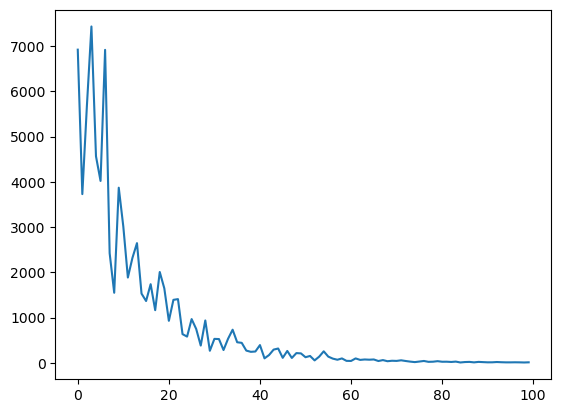

In [45]:
plt.plot(list(range(100)), losses)

In [60]:
def predict(X: ndarray,
            weights: Dict[str, ndarray]) -> ndarray:
    
    N = np.dot(X, weights['W'])
    P = N + weights['B']

    return P

predictions = predict(X, weights)

In [61]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

print("Mean absolute error:", round(mae(predictions, y), 4), "\n"
      "Root mean squared error:", round(rmse(predictions, y), 4))

Mean absolute error: 2.45 
Root mean squared error: 3.024


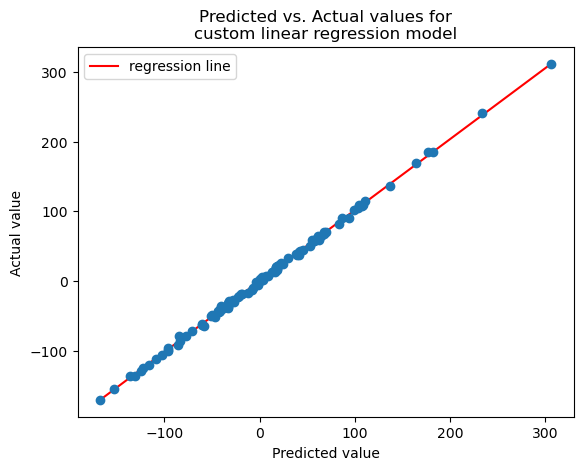

In [66]:
plt.scatter(predictions, y, zorder=2)
plt.plot([predictions.min(), predictions.max()], [y.min(), y.max()], color='r', label='regression line', zorder=1)
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.title("Predicted vs. Actual values for\ncustom linear regression model")
plt.legend()
plt.show()